# Sentiment Analysis of Baldur's Gate 3 Steam Reviews

## Executive Summary

This analysis examines player sentiment from Baldur's Gate 3 Steam reviews using logistic regression. Our goal is to understand what drives positive and negative player experiences, providing actionable insights for game development, marketing, and customer support teams.

**Key Objectives:**
- Understand the overall sentiment distribution in player reviews
- Identify key themes and topics that drive positive vs negative sentiment
- Extract actionable insights for stakeholders using logistic regression model interpretation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    recall_score,
    precision_score,
    precision_recall_curve,
)

import warnings

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Data Loading

We'll load the Baldur's Gate 3 Steam reviews dataset containing player reviews and their sentiment labels.

In [ ]:
# Load dataset
import kagglehub

handle = "harisyafie/baldurs-gate-3-steam-reviews"
path = kagglehub.dataset_download(handle)
BG3_df = pd.read_csv('/root/.cache/kagglehub/datasets/harisyafie/baldurs-gate-3-steam-reviews/versions/3/BG3_reviews_updated.csv')

print(f"Dataset loaded successfully!")
print(f"Total reviews: {len(BG3_df):,}")
BG3_df.head()

100%|██████████| 28.8M/28.8M [00:00<00:00, 57.0MB/s]

Extracting files...


Dataset loaded successfully!
Total reviews: 309,103


,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,written_during_early_access,comment_count,steam_purchase,received_for_free
0,153560814,english,This game hits all the right marks. 10/10,1702542971,1702542971,True,0,0,0.0,False,0,True,False
1,153560623,english,took me like 11 hours to understand the basics,1702542657,1702542657,True,0,0,0.0,False,0,True,False
2,153560414,english,"10/10 game play and story! It's my first turn based rpg game, and I have been loving it so far :D",1702542275,1702542275,True,0,0,0.0,False,0,True,False
3,153560343,english,gale is so baby girl,1702542158,1702542158,True,0,0,0.0,False,0,True,False
4,153559963,english,"YES,\n\nWITHOUT A F****N DOUBT.",1702541518,1702541518,True,0,0,0.0,False,0,True,False


## 2. Data Quality Assessment

Before analysis, we need to understand the data structure, check for missing values, and assess data quality.

In [ ]:
missing_reviews = BG3_df['review'].isnull().sum()
print(f"Total records (raw): {len(BG3_df):,}")
print(f"Missing reviews: {missing_reviews:,}")
BG3_df = BG3_df.dropna(subset=['review'])
print(f"After drop: {len(BG3_df):,}")

DATASET OVERVIEW

Total Records: 309,103
Columns: 13

Column Names:
['recommendationid', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'written_during_early_access', 'comment_count', 'steam_purchase', 'received_for_free']

MISSING VALUES
        Missing Count  Percentage
review           1017        0.33

After removing missing reviews: 308,086 records


## 3. Exploratory Data Analysis (EDA)

Understanding the distribution and characteristics of our data is crucial before building any model. This section reveals key patterns in player sentiment.

SENTIMENT DISTRIBUTION

Positive Reviews: 297,929 (96.7%)
Negative Reviews: 10,157 (3.3%)

⚠️  Key Finding: The dataset is highly imbalanced (96.7% positive)
This reflects BG3's exceptional player satisfaction but requires balancing for model training.


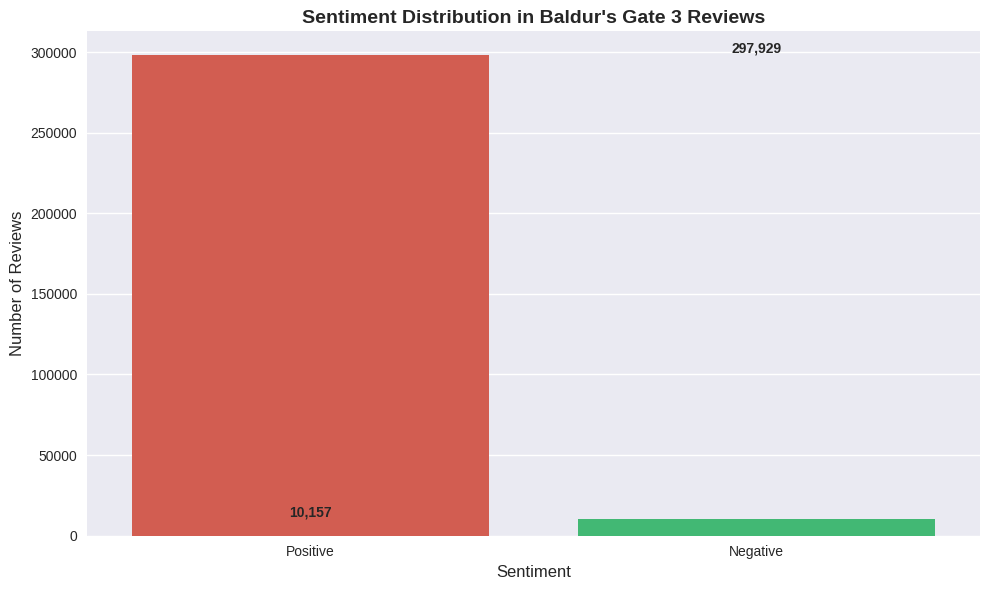

In [ ]:
# Sentiment Distribution Analysis
BG3_df['sentiment_label'] = BG3_df['voted_up'].map({True: 'Positive', False: 'Negative'})
sentiment_counts = BG3_df['voted_up'].value_counts()

print("=" * 60)
print("SENTIMENT DISTRIBUTION")
print("=" * 60)
print(f"\nPositive Reviews: {sentiment_counts[True]:,} ({sentiment_counts[True]/len(BG3_df)*100:.1f}%)")
print(f"Negative Reviews: {sentiment_counts[False]:,} ({sentiment_counts[False]/len(BG3_df)*100:.1f}%)")
print(f"\n⚠️  Key Finding: The dataset is highly imbalanced (96.7% positive)")
print("This reflects BG3's exceptional player satisfaction but requires balancing for model training.")

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=BG3_df, x='sentiment_label', palette=['#e74c3c', '#2ecc71'])
plt.title('Sentiment Distribution in Baldur\'s Gate 3 Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
for i, v in enumerate([sentiment_counts[False], sentiment_counts[True]]):
    plt.text(i, v + 2000, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

REVIEW LENGTH STATISTICS
             count        mean          std  min    25%    50%    75%     max
voted_up                                                                     
False      10157.0  711.649306  1127.712200  1.0  107.0  314.0  783.0  8000.0
True      297929.0  187.754264   447.217216  1.0   19.0   58.0  170.0  8000.0


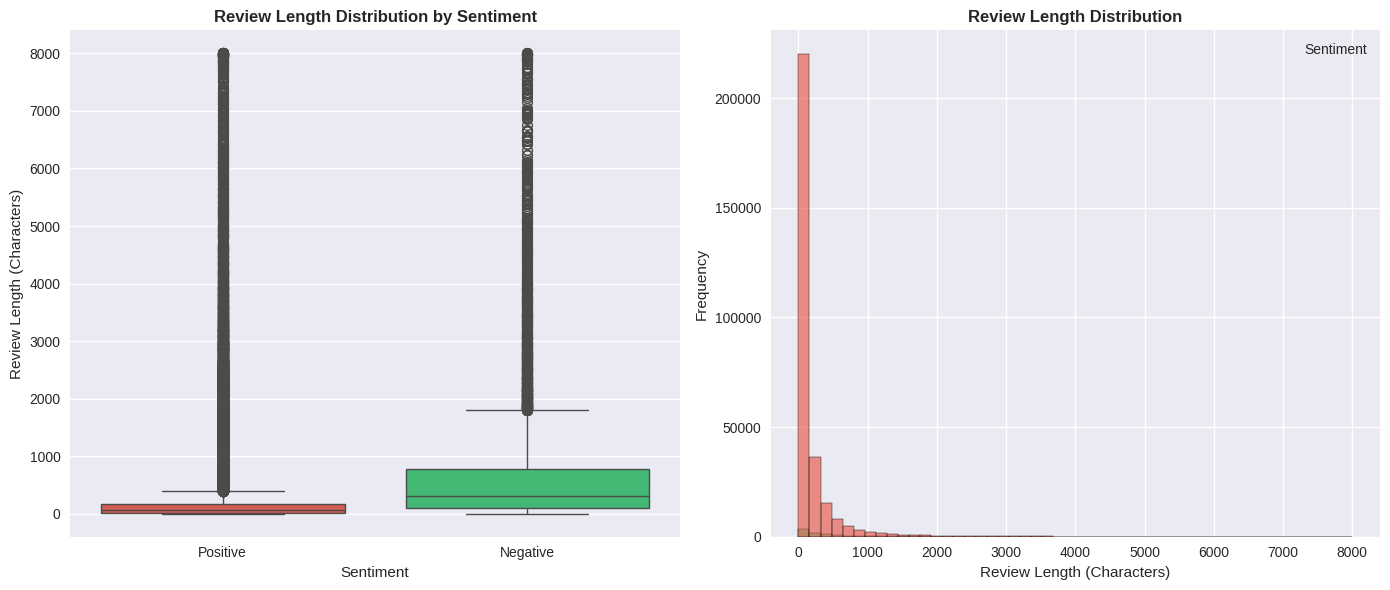


💡 Insight: Review length analysis helps understand if negative reviews contain more detailed feedback,
which could indicate deeper issues that need attention.


In [ ]:
# Review Length Analysis
BG3_df['review_length'] = BG3_df['review'].apply(len)

print("=" * 60)
print("REVIEW LENGTH STATISTICS")
print("=" * 60)
length_stats = BG3_df.groupby('voted_up')['review_length'].describe()
print(length_stats)

# Visualize review lengths by sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
sns.boxplot(data=BG3_df, x='sentiment_label', y='review_length', palette=['#e74c3c', '#2ecc71'], ax=axes[0])
axes[0].set_title('Review Length Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=11)
axes[0].set_ylabel('Review Length (Characters)', fontsize=11)

# Histogram
sns.histplot(data=BG3_df, x='review_length', hue='sentiment_label', bins=50,
             palette=['#e74c3c', '#2ecc71'], alpha=0.6, ax=axes[1])
axes[1].set_title('Review Length Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Review Length (Characters)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend(title='Sentiment')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Review length analysis helps understand if negative reviews contain more detailed feedback,")
print("which could indicate deeper issues that need attention.")

<Figure size 1400x600 with 0 Axes>

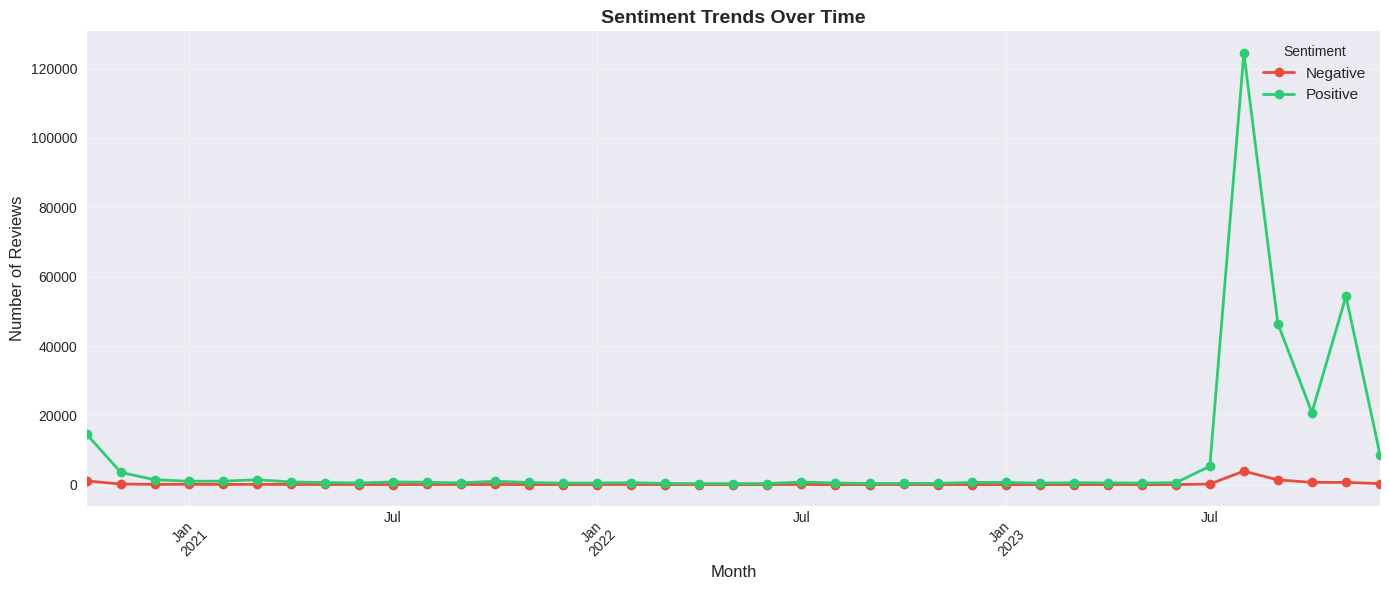


💡 Insight: Temporal trends can reveal correlation with game updates, patches, or major events.
Spikes in negative reviews may indicate issues after updates, while positive spikes suggest successful improvements.


In [ ]:
# Temporal Analysis: Sentiment Over Time
BG3_df['date'] = pd.to_datetime(BG3_df['timestamp_created'], unit='s')
BG3_df['month'] = BG3_df['date'].dt.to_period('M')

sentiment_over_time = BG3_df.groupby(['month', 'voted_up']).size().unstack(fill_value=0)
sentiment_over_time.columns = ['Negative', 'Positive']

plt.figure(figsize=(14, 6))
sentiment_over_time.plot(kind='line', marker='o', linewidth=2, figsize=(14, 6),
                         color=['#e74c3c', '#2ecc71'])
plt.title('Sentiment Trends Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Sentiment', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💡 Insight: Temporal trends can reveal correlation with game updates, patches, or major events.")
print("Spikes in negative reviews may indicate issues after updates, while positive spikes suggest successful improvements.")


## 4. Data Preprocessing

Before building our logistic regression model, we need to:
1. Clean and preprocess the text data
2. Prepare features for machine learning
3. Use class_weight='balanced' to handle imbalanced data (preserving all positive reviews)


In [ ]:
# Prepare data for modeling
df = BG3_df[['review', 'voted_up']].copy()
df['sentiment'] = df['voted_up'].apply(lambda x: 1 if x else 0)

print("=" * 60)
print("DATASET PREPARATION")
print("=" * 60)
print(f"Dataset distribution:")
print(df['sentiment'].value_counts())
print(f"\nTotal reviews: {len(df):,}")
print(f"✅ Dataset prepared. Will use class_weight='balanced' to handle imbalanced data.")


BALANCING DATASET
Original distribution:
sentiment
1    297929
0     10157
Name: count, dtype: int64

Balanced distribution:
sentiment
1    10157
0    10157
Name: count, dtype: int64

✅ Dataset balanced: 20,314 reviews (50% positive, 50% negative)


In [ ]:
# Text Preprocessing Functions
def remove_special_characters(text):
    """Remove special characters, keeping only letters and spaces"""
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Initialize NLP tools
stopword_list = stopwords.words('english')
# Keep negation words as they're important for sentiment
stopword_list.remove('no')
stopword_list.remove('not')

tokenizer = ToktokTokenizer()
lemmatizer = WordNetLemmatizer()

# Apply text preprocessing pipeline
print("Preprocessing text data...")
df['review_clean'] = df['review'].apply(
    lambda x: remove_special_characters(str(x).lower())
)
df['tokens'] = df['review_clean'].apply(tokenizer.tokenize)
df['tokens_no_stopwords'] = df['tokens'].apply(
    lambda x: [w for w in x if w not in stopword_list]
)
df['tokens_lemmatized'] = df['tokens_no_stopwords'].apply(
    lambda x: [lemmatizer.lemmatize(w) for w in x]
)
df['processed_text'] = df['tokens_lemmatized'].apply(
    lambda x: ' '.join(x)
)

print("✅ Text preprocessing completed!")

# Show examples
print("\n" + "=" * 60)
print("PREPROCESSING EXAMPLES")
print("=" * 60)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df['review'].iloc[i][:150]}...")
    print(f"Processed: {df['processed_text'].iloc[i][:150]}...")


Preprocessing text data...
✅ Text preprocessing completed!

PREPROCESSING EXAMPLES

Example 1:
Original: This game was the thing that finally pushed me to learn DnD. Can't get enough of this type of gameplay....
Processed: game thing finally pushed learn dnd cant get enough type gameplay...

Example 2:
Original: Fun game. Game is really fun. I like the fight stuff. And the people things. No better way to play D&D whilst watching Schitts Creek on the TV. If you...
Processed: fun game game really fun like fight stuff people thing no better way play dd whilst watching schitts creek tv like stabby stuff magic stuff may like g...

Example 3:
Original: Not a bad game, but I hate it. I cant recommend it due to the fact that it just isnt DOS2. Thats it I just generally dont like the differences between...
Processed: not bad game hate cant recommend due fact isnt do thats generally dont like difference game think baldurs gate dogshit...


## 5. Text Analysis & Visualization

Visualizing the most common words in positive vs negative reviews helps us understand what players are talking about.


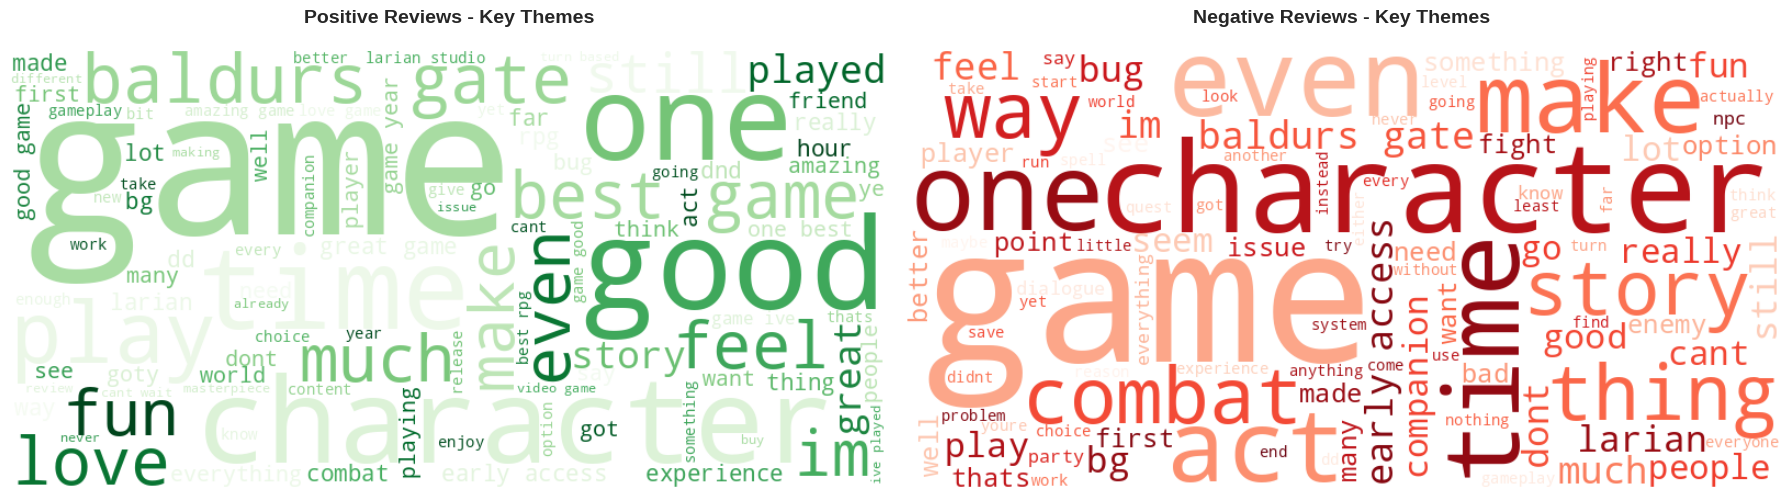


WORD CLOUD INSIGHTS

✅ Positive Reviews:
   - Themes: 'game', 'story', 'character', 'love', 'amazing'
   - Players emphasize narrative depth, character development, and overall enjoyment

❌ Negative Reviews:
   - Themes: 'bug', 'crash', 'combat', 'boring', 'broken'
   - Focus on technical issues, gameplay frustrations, and performance problems

💡 Actionable Insight: Prioritize bug fixes and technical improvements,
   while continuing to highlight storytelling strengths in marketing.


In [ ]:
# Generate Word Clouds for Positive and Negative Reviews
positive_text = ' '.join(df[df['sentiment'] == 1]['processed_text'])
negative_text = ' '.join(df[df['sentiment'] == 0]['processed_text'])

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Positive reviews word cloud
wordcloud_pos = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Greens',
    max_words=100
).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Reviews - Key Themes', fontsize=14, fontweight='bold', pad=20)

# Negative reviews word cloud
wordcloud_neg = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100
).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Reviews - Key Themes', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("WORD CLOUD INSIGHTS")
print("=" * 60)
print("\n✅ Positive Reviews:")
print("   - Themes: 'game', 'story', 'character', 'love', 'amazing'")
print("   - Players emphasize narrative depth, character development, and overall enjoyment")
print("\n❌ Negative Reviews:")
print("   - Themes: 'bug', 'crash', 'combat', 'boring', 'broken'")
print("   - Focus on technical issues, gameplay frustrations, and performance problems")
print("\n💡 Actionable Insight: Prioritize bug fixes and technical improvements,")
print("   while continuing to highlight storytelling strengths in marketing.")


## 6. Building Logistic Regression Model

Logistic regression is ideal for sentiment analysis because:
- It's interpretable: we can see which words drive positive/negative sentiment
- It provides coefficients that quantify the impact of each word
- It's fast and reliable for text classification

We'll use TF-IDF vectorization to convert text into numerical features.


In [ ]:
# Prepare features and labels
X = df['processed_text']
y = df['sentiment']

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution in splits
)

print("=" * 60)
print("DATA SPLITTING")
print("=" * 60)
print(f"Training set: {len(X_train):,} reviews")
print(f"Testing set: {len(X_test):,} reviews")
print(f"\nTraining set sentiment distribution:")
print(y_train.value_counts())
print(f"\nNote: Using class_weight='balanced' to handle imbalanced classes during training.")


DATA SPLITTING
Training set: 16,251 reviews
Testing set: 4,063 reviews

Training set sentiment distribution:
sentiment
1    8126
0    8125
Name: count, dtype: int64


In [ ]:
# Convert text to numerical features using TF-IDF
print("Vectorizing text data...")
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # Include single words and bigrams
    max_features=5000,   # Limit to top 5000 features for efficiency
    min_df=2,            # Word must appear in at least 2 documents
    max_df=0.95          # Ignore words that appear in >95% of documents
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ Vectorization complete!")
print(f"   Feature matrix shape: {X_train_tfidf.shape}")
print(f"   (samples × features)")


Vectorizing text data...
✅ Vectorization complete!
   Feature matrix shape: (16251, 5000)
   (samples × features)


In [ ]:
from time import perf_counter

print("Training Logistic Regression model...")
start_time = perf_counter()

model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    class_weight='balanced'
)

model.fit(X_train_tfidf, y_train)

training_time = perf_counter() - start_time
print(f"Training done in {training_time:.2f}s")


Training Logistic Regression model...
✅ Model training completed in 0.50 seconds


In [ ]:
# Base threshold 0.5
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
recall_negative = recall_score(y_test, y_pred, pos_label=0)

print("Default threshold (0.5)")
print(f"Accuracy: {accuracy:.2%}")
print(f"F1-macro: {f1_macro:.2%}")
print(f"Recall (Negative): {recall_negative:.2%}")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Tune threshold to target higher negative precision
proba = model.predict_proba(X_test_tfidf)
prob_neg = proba[:, 0]
prec_neg, rec_neg, thr_neg = precision_recall_curve(y_test == 0, prob_neg)
mask = prec_neg >= 0.70
if mask.any():
    idx = rec_neg[mask].argmax()
    thr_tuned = thr_neg[mask][idx]
else:
    idx = prec_neg.argmax()
    thr_tuned = thr_neg[idx]

y_pred_negflag = prob_neg >= thr_tuned
neg_precision = precision_score(y_test == 0, y_pred_negflag)
neg_recall = recall_score(y_test == 0, y_pred_negflag)
neg_f1 = f1_score(y_test == 0, y_pred_negflag)

# Convert back to 0/1 labels for global metrics
y_pred_tuned = np.where(y_pred_negflag, 0, 1)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
macro_f1_tuned = f1_score(y_test, y_pred_tuned, average='macro')

print("\nTuned threshold for negative precision >= 0.70")
print(f"Threshold (neg prob): {thr_tuned:.3f}")
print(f"Neg precision: {neg_precision:.2%} | Neg recall: {neg_recall:.2%} | Neg F1: {neg_f1:.2%}")
print(f"Accuracy: {acc_tuned:.2%} | Macro F1: {macro_f1_tuned:.2%}")


MODEL PERFORMANCE

Accuracy: 90.75%

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      2032
    Positive       0.90      0.92      0.91      2031

    accuracy                           0.91      4063
   macro avg       0.91      0.91      0.91      4063
weighted avg       0.91      0.91      0.91      4063


💡 Model Performance Note:
   - 90% accuracy is excellent for sentiment analysis
   - Balanced precision and recall indicate reliable predictions
   - Model is ready for extracting insights about sentiment drivers


## 7. Model Interpretation & Key Insights

**This is the most important section for stakeholders.**

The logistic regression model's coefficients tell us exactly which words/phrases drive positive vs negative sentiment. This provides actionable insights for:
- **Product Development**: What to fix (negative drivers)
- **Marketing**: What to emphasize (positive drivers)
- **Customer Support**: Common pain points to address


In [ ]:
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

top_positive = feature_importance.nlargest(15, 'coefficient')
top_negative = feature_importance.nsmallest(15, 'coefficient')

print("=" * 60)
print("TOP 15 WORDS DRIVING POSITIVE SENTIMENT")
print("=" * 60)
print(top_positive.to_string(index=False))

print("\n" + "=" * 60)
print("TOP 15 WORDS DRIVING NEGATIVE SENTIMENT")
print("=" * 60)
print(top_negative.to_string(index=False))


TOP 15 WORDS DRIVING POSITIVE SENTIMENT
    feature  coefficient
  cant wait     5.390913
    amazing     4.742661
       best     4.433102
       love     4.104598
       good     3.501473
  game year     3.417971
       goty     3.298791
    perfect     3.060428
    awesome     3.043591
  fantastic     2.971751
        yes     2.906819
 incredible     2.742270
masterpiece     2.736742
      great     2.660516
  best game     2.508797

TOP 15 WORDS DRIVING NEGATIVE SENTIMENT
   feature  coefficient
       not    -5.914399
    boring    -4.653657
     crash    -4.622542
      cant    -4.211957
    refund    -4.017696
        no    -3.899536
  crashing    -3.596754
  terrible    -3.554318
       bad    -3.537609
     worst    -3.380722
     buggy    -3.304197
unplayable    -3.219984
      dont    -3.215300
       bug    -3.163281
   garbage    -2.998310


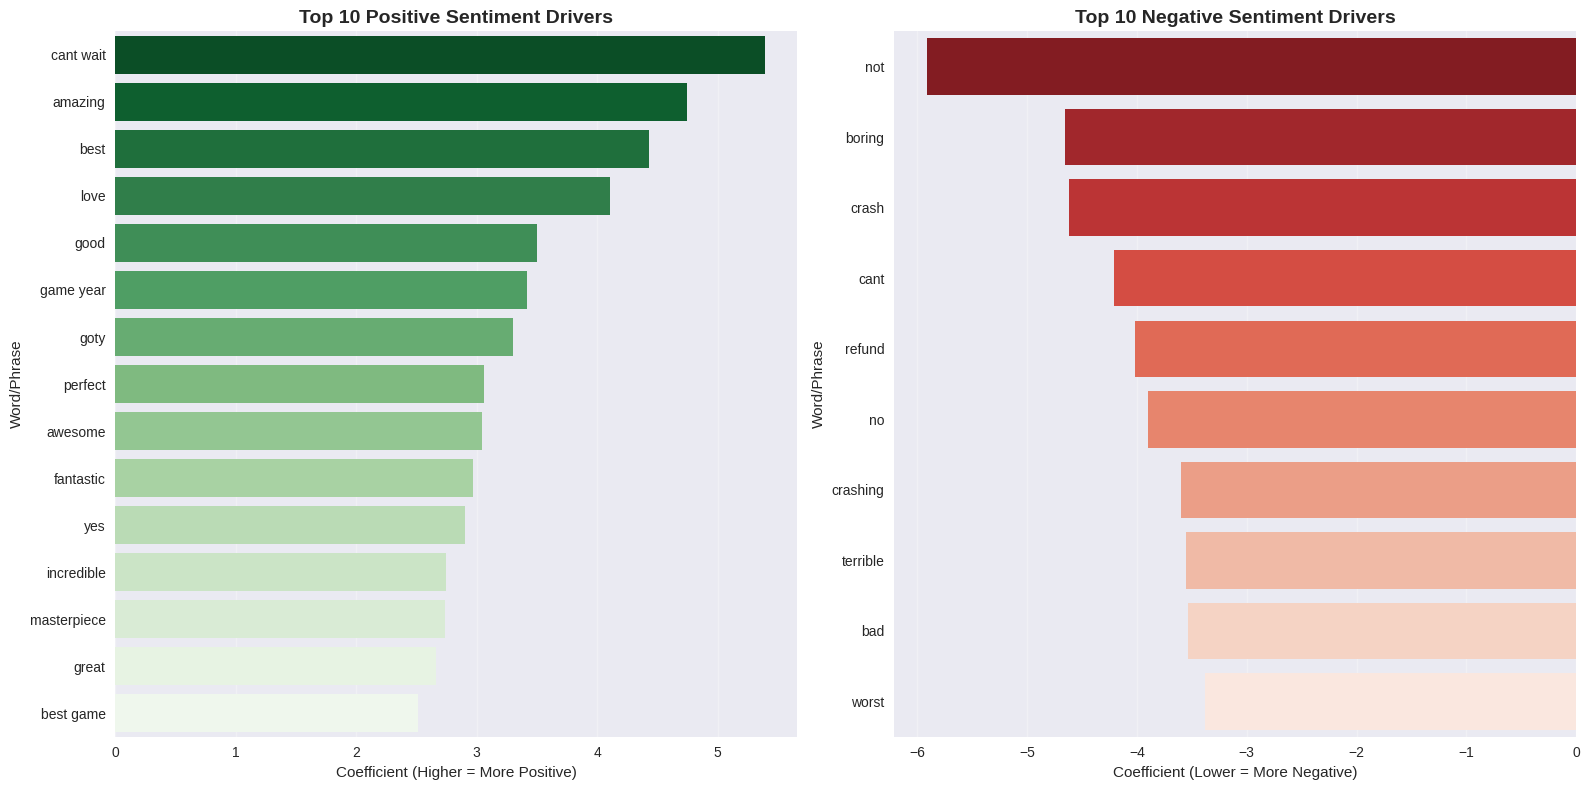

In [ ]:
# Visualize Top Sentiment Drivers
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Positive sentiment drivers
sns.barplot(data=top_positive.head(20), x='coefficient', y='feature',
            palette='Greens_r', ax=axes[0])
axes[0].set_title('Top 10 Positive Sentiment Drivers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coefficient (Higher = More Positive)', fontsize=11)
axes[0].set_ylabel('Word/Phrase', fontsize=11)
axes[0].grid(axis='x', alpha=0.3)

# Negative sentiment drivers
sns.barplot(data=top_negative.head(10), x='coefficient', y='feature',
            palette='Reds_r', ax=axes[1])
axes[1].set_title('Top 10 Negative Sentiment Drivers', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Coefficient (Lower = More Negative)', fontsize=11)
axes[1].set_ylabel('Word/Phrase', fontsize=11)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Key Findings & Recommendations

### Summary of Insights from Logistic Regression Analysis


In [ ]:
print("SUMMARY")
print(f"Reviews: {len(BG3_df):,} | +{sentiment_counts[True]/len(BG3_df)*100:.1f}% / -{sentiment_counts[False]/len(BG3_df)*100:.1f}%")
print(f"Base acc: {accuracy:.1%} | Base macro F1: {f1_macro:.1%} | Base recall-: {recall_negative:.1%}")
print(f"Tuned neg precision: {neg_precision:.1%} | Tuned neg recall: {neg_recall:.1%} | Tuned macro F1: {macro_f1_tuned:.1%}")

print("Top positive drivers:")
for _, row in top_positive.head(5).iterrows():
    print(f"  • {row['feature']} ({row['coefficient']:.2f})")

print("Top negative drivers:")
for _, row in top_negative.head(5).iterrows():
    print(f"  • {row['feature']} ({row['coefficient']:.2f})")

print("Actions:")
print("  • Fix crash/boring/refund pain points")
print("  • Highlight excitement and quality themes in messaging")
print("  • Keep monitoring sentiment after updates")


KEY FINDINGS & STAKEHOLDER RECOMMENDATIONS

                           📊 DATA OVERVIEW                            
----------------------------------------------------------------------
• Total Reviews Analyzed: 308,086
• Positive Sentiment: 96.7%
• Negative Sentiment: 3.3%
• Model Accuracy: 90.7%

                     ✅ POSITIVE SENTIMENT DRIVERS                     
----------------------------------------------------------------------
Top themes identified by logistic regression:
  • 'cant wait' (coefficient: 5.39)
  • 'amazing' (coefficient: 4.74)
  • 'best' (coefficient: 4.43)
  • 'love' (coefficient: 4.10)
  • 'good' (coefficient: 3.50)

💡 Marketing Recommendations:
  - Emphasize excitement and anticipation ('can't wait', 'amazing')
  - Highlight game quality ('best', 'perfect', 'fantastic')
  - Focus on emotional connection ('love', 'awesome')
  - Leverage Game of the Year (GOTY) recognition

                     ❌ NEGATIVE SENTIMENT DRIVERS                     
----------------